**1. 워드클라우드**  
- 명사만 추출해서 보이는 게 더 명확해 보임  

**2. 토픽모델링**
- 쉽게 말하자면 명사, 동사, 형용사 위주의 형태소만 추출

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import gzip
%matplotlib inline

In [ ]:
## 데이터 불러오기
train = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/sample_submission.csv', encoding = 'utf-8')

In [ ]:
# 제목, 내용 분리
train_new = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/train_title and data_0216.csv', encoding = 'utf-8')

# 전처리

In [ ]:
## konlpy, mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-02-26 07:24:41--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-02-26 07:24:41--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccf3427ba9fbe7a9a2af700a471.dl.dropboxusercontent.com/cd/0/get/B3OF47g-EtLHcOHgBEsRvcDyIbWWkcEl8Oihw9nZw0vOgoVI6OW_Y0MR3kwOVEGxRl2ybWDPeoEAweNql1AvmkCmHgW8LIrdsfx1UfGQetzpqxV8jfz0xgPBbPEX83yNjdQgVSXKZ_jvk2d4Phx6uqyJtFlU37pgUbJ3T2rqmfFIvzweJwVVmNlE1b2AvoXIAUI/file?dl=1# [following]
--2023-02-26 07:24:41--  https://uccf3427ba9fbe7a9a2af700a471.dl.dropboxusercontent.com/cd/0/get/B3OF47g-EtLH

## 결측치, 불용어 제거(1)

In [ ]:
np.sum(train.isnull())

index       0
category    0
data        8
dtype: int64

In [ ]:
train.dropna(axis=0, inplace=True)

In [ ]:
np.sum(test.isnull())

index    0
data     0
dtype: int64

In [ ]:
train['data'] = train['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['data'] = test['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 특수문자 제거
train['data'] = train['data'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\\n\t]+', " ", regex=True)
test['data'] = test['data'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', " ", regex=True)
train['data'] = train['data'].str.replace(r'\t+', " ", regex=True)
test['data'] = test['data'].str.replace(r'\t+', " ", regex=True)
train['data'] = train['data'].str.replace(r'[\\n]+'," ", regex=True)
test['data'] = test['data'].str.replace(r'[\\n]+'," ", regex=True)

<ipython-input-9-709a20f71fbe>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['data'] = train['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-9-709a20f71fbe>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['data'] = test['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


## 필요없는 문장(짧은 문장) 제거

In [ ]:
## 가장 짧은 문장은 삭제(길이=1)
pop_index = list(np.where(train['data'].apply(len)==1)[0])

In [ ]:
train.drop(pop_index,inplace=True)
train.reset_index(inplace=True,drop=True)

In [ ]:
## 그 다음으로 짧은 문장 삭제(길이=3)
pop_index = list(np.where(train['data'].apply(len)==3)[0])
train.drop(pop_index,inplace=True)
train.reset_index(inplace=True,drop=True)

train data의 최소 길이 :  5
train data의 최대 길이 :  28481
train data의 평균 길이 :  499.7098871964183


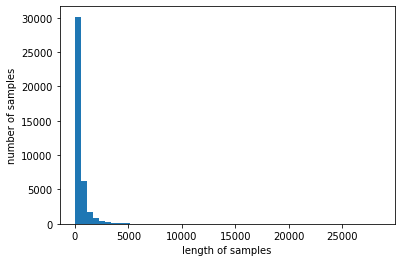

In [ ]:
print('train data의 최소 길이 : ', min(map(len, train['data'])))
print('train data의 최대 길이 : ', max(map(len, train['data'])))
print('train data의 평균 길이 : ', sum(map(len, train['data'])) / len(train['data']))
plt.hist([len(s) for s in train['data']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최소 길이 :  8
test data의 최대 길이 :  22394
test data의 평균 길이 :  502.223


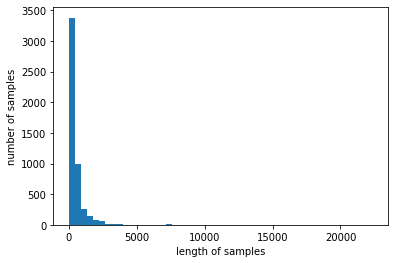

In [ ]:
print('test data의 최소 길이 : ', min(map(len, test['data'])))
print('test data의 최대 길이 : ', max(map(len, test['data'])))
print('test data의 평균 길이 : ', sum(map(len, test['data'])) / len(test['data']))
plt.hist([len(s) for s in test['data']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# -----여기까지 하고 LDA 토픽 모델링(NEW) --------

## 형태소 추출
- 일반명사, 고유명사, 형용사, 동사, 어근  
- 잘 안되면 길이 1 이상 되는 애들만 추출

In [ ]:
train2 = train[train['category']==2]
train1 = train[train['category']==1]
train0 = train[train['category']==0]

In [ ]:
train2.reset_index(inplace=True,drop=True)
train1.reset_index(inplace=True,drop=True)
train0.reset_index(inplace=True,drop=True)

### 모든 train data

In [ ]:
from konlpy.tag import Mecab

In [ ]:
train_word = []

for document in train['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG', 'NNP', 'VA', 'VV', 'XR']: #일반명사, 고유명사, 형용사, 동사, 어근
            train_word.append(word[0])

In [ ]:
with gzip.open('train_word.pickle', 'wb') as f:
    pickle.dump(train_word, f)

### category = 0 (인권/성평등)

In [ ]:
train0_word = []

for document in train0['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG', 'NNP', 'VA', 'VV' 'XR']: #일반명사, 고유명사, 형용사, 동사, 어근
            train0_word.append(word[0])

In [ ]:
# Counter(train0_word).most_common(100)

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','가','때문','왜','들','또','다'}
train0_word = [i for i in train0_word if i not in remove_set]

In [ ]:
with gzip.open('train0_word.pickle', 'wb') as f:
    pickle.dump(train0_word, f)

### category = 1 (문화/예술/체육/언론)

In [ ]:
train1_word = []

for document in train1['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG', 'NNP', 'VA', 'VV', 'XR'] : #일반명사, 고유명사, 형용사, 동사, 어근
            train1_word.append(word[0])

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','가','때문','왜','들','또','다'}

train1_word = [i for i in train1_word if i not in remove_set]

In [ ]:
with gzip.open('train1_word.pickle', 'wb') as f:
    pickle.dump(train1_word, f)

### category = 2 (육아/교육)

In [ ]:
train2_word = []

for document in train2['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG', 'NNP', 'VA', 'VV', 'XR']: #일반명사, 고유명사, 형용사, 동사, 어근
            train2_word.append(word[0])

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','가','때문','왜','들','또'}

train2_word = [i for i in train2_word if i not in remove_set]

In [ ]:
with gzip.open('train2_word.pickle', 'wb') as f:
    pickle.dump(train2_word, f)

## 형태소 추출(명사만)

### 모든 train data

In [ ]:
from konlpy.tag import Mecab

In [ ]:
train_word = []

for document in train['data']:
    mecab = Mecab()
    word = mecab.nouns(document)
    train_word.append(word)

In [ ]:
train_noun = []

for i in range(len(train_word)):
  train_noun += train_word[i]

train_word = train_noun

In [ ]:
remove_set = {'것','수','말','저','등','이','때','제','게','중','거','그','때문','분','원','경우','만','명','내','후','건','월','전','부','나','하나','저희','년'}

train_word = [i for i in train_word if i not in remove_set]

### category = 0 (인권/성평등)

In [ ]:
train0_word = []

for document in train0['data']:
    mecab = Mecab()
    word = mecab.nouns(document)
    train0_word.append(word)

In [ ]:
train0_word_list = []
train0_word_list = train0_word

train0_noun = []

for i in range(len(train0_word)):
  train0_noun += train0_word[i]

train0_word = train0_noun

In [ ]:
remove_set = {'것','수','말','저','등','이','때','제','게','중','거','그','때문','분','원','경우','만','명','내','후','건','월','전','부','나','하나','저희','년'}

train0_word = [i for i in train0_word if i not in remove_set]

### category = 1 (문화/예술/체육/언론)

In [ ]:
train1_word = []

for document in train1['data']:
    mecab = Mecab()
    word = mecab.nouns(document)
    train1_word.append(word)

In [ ]:
train1_noun = []

for i in range(len(train1_word)):
  train1_noun += train1_word[i]

train1_word = train1_noun

In [ ]:
remove_set = {'것','수','일','년','등','이','저','때','거','원','게','중','그','분','만','번','전','건','제','명','월','데','년'}

train1_word = [i for i in train1_word if i not in remove_set]

### category = 2 (육아/교육)

In [ ]:
train2_word = []

for document in train2['data']:
    mecab = Mecab()
    word = mecab.nouns(document)
    train2_word.append(word)

In [ ]:
train2_noun = []

for i in range(len(train2_word)):
  train2_noun += train2_word[i]

train2_word = train2_noun

In [ ]:
remove_set = {'것','수','일','저','년','등','때','중','원','거','때문','이','게','만','후','명','번','분','월','전','데','년'}

train2_word = [i for i in train2_word if i not in remove_set]

# LDA 토픽 모델링 -- 수정 필요(질문)
- **Q. 명사만 뽑는 게 나을까?**  
- 일반명사, 고유명사, 형용사, 동사, 어근
- **아래 블로그를 그대로 따라한 거라 코드 수정해야 함!**
- 참고 : [링크1](https://heytech.tistory.com/401), [링크2](https://velog.io/@mare-solis/LDA-%ED%86%A0%ED%94%BD-%EB%AA%A8%EB%8D%B8%EB%A7%81%EC%9C%BC%EB%A1%9C-%EC%BD%98%ED%85%90%EC%B8%A0-%EB%A6%AC%EB%B7%B0%EB%A5%BC-%EB%B6%84%EC%84%9D%ED%95%98%EC%9E%90)


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.9 MB/s eta 0:00:00


In [ ]:
from gensim import corpora # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # LDA 시각화용 패키지

In [ ]:
NUM_TOPICS = 3 # 토픽 개수는 하이퍼파라미터
# NUM_TOPICS = 5

# passes: 딥러닝에서 Epoch와 같은 개념으로, 전체 corpus로 모델 학습 횟수 결정
PASSES = 15

In [ ]:
from scipy.sparse.construct import numbers
def lda_modeling(review_prep, num):
    # 단어 인코딩 및 빈도수 계산
    dictionary = corpora.Dictionary(review_prep)
    corpus = [dictionary.doc2bow(review) for review in review_prep]

    # LDA 모델 학습
    model = gensim.models.ldamodel.LdaModel(corpus,
                                            num_topics = num,  # num -> NUM_TOPICS
                                            id2word = dictionary,
                                            passes = PASSES)
    return model, corpus, dictionary

In [ ]:
def print_topic_prop(topics, num):
    topic_values = []
    for topic in topics:
        topic_value = topic[1]
        topic_values.append(topic_value)
    topic_prop = pd.DataFrame({"topic_num" : list(range(1, num + 1)), "word_prop": topic_values}) # num -> NUM_TOPCIS
    return topic_prop

In [ ]:
model0, corpus0, dictionary0 = lda_modeling([train0_word],5)
model1, corpus1, dictionary1 = lda_modeling([train1_word],5)
model2, corpus2, dictionary2 = lda_modeling([train2_word],5)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
NUM_WORDS = 10

topics0 = model0.print_topics(num_words = NUM_WORDS)
df_train0 = print_topic_prop(topics0,5)
topics1 = model1.print_topics(num_words = NUM_WORDS)
df_train1 = print_topic_prop(topics1,5)
topics2 = model2.print_topics(num_words = NUM_WORDS)
df_train2 = print_topic_prop(topics2,5)

In [ ]:
lda_visualization0 = gensimvis.prepare(model0, corpus0, dictionary0, sort_topics=False)
pyLDAvis.save_html(lda_visualization0, 'model0.html')
lda_visualization1 = gensimvis.prepare(model1, corpus1, dictionary1, sort_topics=False)
pyLDAvis.save_html(lda_visualization1, 'model1.html')
lda_visualization2 = gensimvis.prepare(model2, corpus2, dictionary2, sort_topics=False)
pyLDAvis.save_html(lda_visualization2, 'model2.html')

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization0)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization1)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization2)

# LDA 토픽 모델링(NEW) - 전체 데이터

In [ ]:
## 위에서 전처리까지 다 하고 내려오기
train

,index,category,data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요 국민세금으로 일부를 위한 정책펴지 마...
1,1,0,학교이름에 남자도 붙여주세요 울산여자중학교에 재학중인 학생입니다 최근 양성평등 글짓...
2,2,1,빙상연맹 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요 최근 동계올림픽에...
3,3,1,티비 세세 관람가도 연령확인 의무화 하자 제기 에전에 티비를 보다가 잠시 딴일이 생...
4,4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야 무더운 여름철에는 남성들도 노넥타이...
...,...,...,...
39980,39995,2,시간유연근무제 저는 국립대에서 일하고 있는 비정규직 근로자입니다동시에 두 자녀의 ...
39981,39996,0,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다 소년법...
39982,39997,2,무서운데 지켜야 할게 있어요 도와주세요 안녕하세요 한부모엄마 입니다양육비를 받고 ...
39983,39998,2,교복에 고정식 이름표를 달게 하는 것을 금지해 주세요 교복에 이름표를 박아놓아 탈...


In [ ]:
text = train[['data']]
text.head(5)

,data
0,신혼부부위한 주택정책 보다 보육시설 늘려주세요 국민세금으로 일부를 위한 정책펴지 마...
1,학교이름에 남자도 붙여주세요 울산여자중학교에 재학중인 학생입니다 최근 양성평등 글짓...
2,빙상연맹 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요 최근 동계올림픽에...
3,티비 세세 관람가도 연령확인 의무화 하자 제기 에전에 티비를 보다가 잠시 딴일이 생...
4,무더운 여름철엔 남성들도 시원한 자율복장을 해야 무더운 여름철에는 남성들도 노넥타이...


In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()
text['data'] = text.apply(lambda row: mecab.nouns(row['data']),axis=1)

<ipython-input-14-d045c71bd9e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['data'] = text.apply(lambda row: mecab.nouns(row['data']),axis=1)


In [ ]:
print(text.head(5))

                                                data
0  [신혼, 부부, 주택, 정책, 보육, 시설, 국민, 세금, 일부, 정책, 보편, 국...
1  [학교, 이름, 남자, 울산, 여자, 중학교, 재학, 중, 학생, 최근, 양성, 평...
2  [빙상, 연맹, 축구, 협회, 등, 각종, 체육, 협회, 비리, 철저, 최근, 동계...
3  [티비, 세세, 관람, 연령, 확인, 의무, 전, 티비, 일, 동생, 리모컨, 알,...
4  [여름철, 남성, 자율, 복장, 여름철, 남성, 넥타이, 반바지, 등, 복장, 정부...


In [ ]:
remove_set = {'것','수','말','저','등','이','때','제','게','중','거','그','때문','분','원','경우','만','명','내','후','건','월','전','부','나','하나','저희','년'}

text['data'] = text['data'].apply(lambda x: [word for word in x if word not in (remove_set)])

<ipython-input-16-4f1910a6ecad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['data'] = text['data'].apply(lambda x: [word for word in x if word not in (remove_set)])


In [ ]:
print(text.head(5))

                                                data
0  [신혼, 부부, 주택, 정책, 보육, 시설, 국민, 세금, 일부, 정책, 보편, 국...
1  [학교, 이름, 남자, 울산, 여자, 중학교, 재학, 학생, 최근, 양성, 평등, ...
2  [빙상, 연맹, 축구, 협회, 각종, 체육, 협회, 비리, 철저, 최근, 동계, 올...
3  [티비, 세세, 관람, 연령, 확인, 의무, 티비, 일, 동생, 리모컨, 알, 방송...
4  [여름철, 남성, 자율, 복장, 여름철, 남성, 넥타이, 반바지, 복장, 정부, 부...


In [ ]:
tokenized_doc = text['data']

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)

dictionary.filter_extremes(no_below=2, no_above=0.5) ##  빈도가 2 이상인 단어와 전체의 50%로 이상 차지하는 단어는 필터링

corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) # 수행된 결과에서 두번째 청원 출력. 첫번째 문서의 인덱스는 0

[(24, 1), (32, 3), (44, 1), (45, 2), (46, 1), (47, 4), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 6), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 4), (63, 1), (64, 1), (65, 1), (66, 7), (67, 1), (68, 1), (69, 1)]


In [ ]:
print(dictionary[66])

학교


In [ ]:
len(dictionary)

29506

In [ ]:
import gensim
NUM_TOPICS = 8 # 20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.041*"학생" + 0.040*"학교" + 0.032*"교육" + 0.014*"생각"')
(1, '0.041*"여성" + 0.017*"남성" + 0.014*"남자" + 0.013*"사회"')
(2, '0.026*"국민" + 0.022*"우리" + 0.017*"나라" + 0.015*"대통령"')
(3, '0.053*"선수" + 0.018*"대표" + 0.018*"축구" + 0.015*"감독"')
(4, '0.013*"방송" + 0.009*"장애" + 0.008*"일" + 0.007*"공무원"')
(5, '0.009*"조사" + 0.008*"기사" + 0.008*"언론" + 0.008*"내용"')
(6, '0.022*"청소년" + 0.021*"사람" + 0.021*"법" + 0.018*"처벌"')
(7, '0.037*"아이" + 0.017*"일" + 0.016*"시간" + 0.015*"교사"')


In [ ]:
print(ldamodel.print_topics())

[(0, '0.041*"학생" + 0.040*"학교" + 0.032*"교육" + 0.014*"생각" + 0.013*"대학" + 0.009*"문제" + 0.009*"공부" + 0.009*"선생" + 0.008*"시험" + 0.008*"수업"'), (1, '0.041*"여성" + 0.017*"남성" + 0.014*"남자" + 0.013*"사회" + 0.012*"여자" + 0.011*"평등" + 0.010*"성" + 0.010*"생각" + 0.010*"인권" + 0.009*"사람"'), (2, '0.026*"국민" + 0.022*"우리" + 0.017*"나라" + 0.015*"대통령" + 0.012*"한국" + 0.012*"정부" + 0.011*"생각" + 0.011*"대한민국" + 0.010*"문화" + 0.010*"사람"'), (3, '0.053*"선수" + 0.018*"대표" + 0.018*"축구" + 0.015*"감독" + 0.014*"국가" + 0.014*"팀" + 0.011*"경기" + 0.011*"스포츠" + 0.011*"국민" + 0.010*"협회"'), (4, '0.013*"방송" + 0.009*"장애" + 0.008*"일" + 0.007*"공무원" + 0.007*"교사" + 0.006*"지역" + 0.006*"기관" + 0.006*"업무" + 0.005*"직원" + 0.005*"학교"'), (5, '0.009*"조사" + 0.008*"기사" + 0.008*"언론" + 0.008*"내용" + 0.008*"사건" + 0.007*"국민" + 0.007*"사실" + 0.007*"게임" + 0.006*"수사" + 0.006*"뉴스"'), (6, '0.022*"청소년" + 0.021*"사람" + 0.021*"법" + 0.018*"처벌" + 0.017*"사건" + 0.016*"폐지" + 0.015*"생각" + 0.015*"피해자" + 0.013*"일" + 0.011*"가해자"'), (7, '0.037*"아이" + 0.017*"일" + 0.016*"시간" + 0

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.2 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.save_html(vis, 'lda_model_topic_8.html')

In [ ]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(2, 0.17449932), (7, 0.813765)]
1 번째 문서의 topic 비율은 [(0, 0.5770639), (1, 0.18939732), (2, 0.0950442), (6, 0.12922496)]
2 번째 문서의 topic 비율은 [(3, 0.9933644)]
3 번째 문서의 topic 비율은 [(1, 0.031288825), (3, 0.12674783), (4, 0.054692235), (5, 0.3347046), (6, 0.24658151), (7, 0.20181179)]
4 번째 문서의 topic 비율은 [(0, 0.08908532), (1, 0.3238143), (2, 0.07610373), (3, 0.08884474), (6, 0.023304837), (7, 0.39624038)]


In [ ]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%),
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [ ]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,7.0,0.8138,"[(2, 0.1744891), (7, 0.81377506)]"
1,1,0.0,0.5771,"[(0, 0.5770637), (1, 0.18939753), (2, 0.095043..."
2,2,3.0,0.9934,"[(3, 0.9933644)]"
3,3,5.0,0.3347,"[(1, 0.03128823), (3, 0.12674776), (4, 0.05469..."
4,4,7.0,0.3962,"[(0, 0.08907673), (1, 0.3238031), (2, 0.076134..."
5,5,1.0,0.5962,"[(0, 0.0125126), (1, 0.59615463), (2, 0.328761..."
6,6,5.0,0.4384,"[(0, 0.13332243), (1, 0.24262826), (2, 0.05657..."
7,7,0.0,0.7879,"[(0, 0.7878884), (4, 0.0866839), (7, 0.11464101)]"
8,8,1.0,0.6394,"[(0, 0.05603953), (1, 0.63938946), (4, 0.17694..."
9,9,5.0,0.4017,"[(1, 0.14674708), (3, 0.012644992), (4, 0.1164..."


# 같은 주제끼리 청원 묶기  --
- 군집화
- 코사인 유사도 활용([링크](https://suy379.tistory.com/100))